In [7]:
import numpy as np
import strawberryfields as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# GLOBAL CONFIGURATIONS

HBAR = 1.0 #Plank
SCALE = np.sqrt(HBAR * np.pi)

def compute_wigner_tomography(
    epsilon: float,
    in_state=(0.0, 0.0),
    eta=1.0,
    gamma=0.0,
    q_pts=50,
    range_q=(-5.0, 5.0),
    range_p=(-5.0, 5.0),
    backend="bosonic",
    Nphi=5,
    phi_clip=3.0
) -> np.ndarray:
    """
    Prepare a single-mode GKP(epsilon, in_state),
    apply pure-loss channel(eta), then approximate the dephasing channel 
    by integrating over many rotation angles phi ~ Normal(0, gamma).

    Args:
      epsilon: GKP finite-squeezing
      in_state: (theta, phi) for GKP
      eta: transmissivity for LossChannel
      gamma: variance of random rotation angle
      q_pts: number of points in q or p dimension for Wigner grid
      range_q, range_p: (min, max) for q and p
      Nphi: number of phi points to discretize
      phi_clip: how many std devs to cover in [-phi_clip*sqrt(gamma), +...]

    Returns:
      2D array W_avg[q_index, p_index]: Wigner function
    """
    # Create the q,p grids
    qvals = np.linspace(range_q[0], range_q[1], q_pts)
    pvals = np.linspace(range_p[0], range_p[1], q_pts)

    # If gamma is extremely small, just do one run without rotation
    if gamma < 1e-12:
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
        eng = sf.Engine(backend)
        state = eng.run(prog).state
        return state.wigner(0, qvals, pvals)

    # Otherwise, discretize phi in ± phi_clip * sqrt(gamma)
    phi_std = np.sqrt(gamma)
    phi_min = -phi_clip * phi_std
    phi_max = +phi_clip * phi_std
    phis = np.linspace(phi_min, phi_max, Nphi)
    dphi = phis[1] - phis[0] # Phi step size

    # Gaussian weights
    w_phi = np.exp(-0.5 * (phis / phi_std)**2)
    w_phi /= np.sqrt(2*np.pi) * phi_std  # PDF(phis)

    W_accum = np.zeros((q_pts, q_pts), dtype=float)

    for i, phi_val in enumerate(phis):
        # Build a fresh Program for each phi
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            # GKP + loss
            sf.ops.GKP(state=in_state, epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]

            # Apply rotation Rgate(phi_val)
            sf.ops.Rgate(phi_val) | q[0]

        eng_phi = sf.Engine(backend)
        state_phi = eng_phi.run(prog_phi).state
        W_phi = state_phi.wigner(0, qvals, pvals)

        # Weighted sum
        W_accum += w_phi[i] * W_phi

    # Multiply by dphi to approximate the integral
    W_avg = W_accum * dphi
    return W_avg

class GKPChannelDataset(Dataset):
    """
    A PyTorch Dataset that samples (eta, gamma) pairs in a given range,
    simulates the Wigner function for a GKP state going through those parameters,
    and stores the flattened Wigner as X and [eta, gamma] as Y.
    """
    def __init__(
        self,
        N: int,
        eps_gkp: float,
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        q_pts=50,
        range_q=(-5.0,5.0),
        range_p=(-5.0,5.0),
        in_state=(0.0, 0.0),
        backend="bosonic"
    ):
        super().__init__()
        self.N = N

        x_list = []
        y_list = []

        # Sample random channel parameters
        etas = np.random.uniform(eta_range[0], eta_range[1], N)
        gammas = np.random.uniform(gamma_range[0], gamma_range[1], N)

        for i in range(N):
            W = compute_wigner_tomography(
                epsilon=eps_gkp,
                in_state=in_state,
                eta=etas[i],
                gamma=gammas[i],
                q_pts=q_pts,
                range_q=range_q,
                range_p=range_p,
                backend=backend
            )
            # Flatten 2D Wigner into a 1D vector
            W_flat = W.flatten().astype(np.float32)

            x_list.append(W_flat)
            y_list.append([etas[i], gammas[i]])

        # Convert to numpy arrays
        self.x_data = np.array(x_list, dtype=np.float32)  # shape (N, q_pts^2)
        self.y_data = np.array(y_list, dtype=np.float32)  # shape (N, 2)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

##############################################################################
# 3) SIMPLE FEED-FORWARD NEURAL NETWORK REGRESSOR
##############################################################################

class SimpleRegressor(nn.Module):
    """
    Maps a flattened Wigner distribution of size (q_pts^2) to [eta, gamma].
    """
    def __init__(self, input_dim: int, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # final output => [eta, gamma]
        )

    def forward(self, x):
        return self.net(x)

##############################################################################
# 4) TRAINING + TESTING PIPELINE
##############################################################################

def train_model(
    N_train=5000,
    N_test=500,
    q_pts=32,
    eps_gkp=0.05,
    in_state=(0,0),
    range_q=(-6,6),
    range_p=(-6,6),
    n_epochs=30,
    batch_size=32,
    lr=1e-3,
    hidden_dim=128
):
    """
    Builds datasets, trains the model, returns (model, train_losses, test_losses).
    """
    # 1) Create datasets
    train_dataset = GKPChannelDataset(
        N_train,
        eps_gkp=eps_gkp,
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1),
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        in_state=in_state,
        backend="bosonic"
    )
    test_dataset = GKPChannelDataset(
        N_test,
        eps_gkp=eps_gkp,
        eta_range=(0.5, 1.0),
        gamma_range=(0.0, 1.0),
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        in_state=in_state,
        backend="bosonic"
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # 2) Build model
    input_dim = q_pts*q_pts
    model = SimpleRegressor(input_dim, hidden_dim=hidden_dim)

    # 3) Setup optimizer & loss
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses  = []

    # 4) Training loop
    for epoch in range(n_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(x_batch)
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        # Validation on test set
        model.eval()
        test_loss_val = 0.0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                preds = model(x_batch)
                loss_val = criterion(preds, y_batch)
                test_loss_val += loss_val.item() * x_batch.size(0)
        epoch_test_loss = test_loss_val / len(test_loader.dataset)

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch+1}/{n_epochs}:",
              f"train MSE={epoch_train_loss:.6f},",
              f"test MSE={epoch_test_loss:.6f}")

    return model, train_losses, test_losses

def plot_training_performance(train_losses, test_losses):
    """
    Plots the training vs. test MSE across epochs.
    """
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Model Training Performance")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_single_example(
    model: nn.Module,
    eta_true: float,
    gamma_true: float,
    eps_gkp=0.05,
    in_state=(0,0),
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6)
):
    """
    Generate one Wigner tomography for (eta_true, gamma_true),
    feed to model, return predicted (eta_pred, gamma_pred).
    """
    W_new = compute_wigner_tomography(
        epsilon=eps_gkp,
        in_state=in_state,
        eta=eta_true,
        gamma=gamma_true,
        q_pts=q_pts,
        range_q=range_q,
        range_p=range_p,
        backend="bosonic"
    )
    x_new = torch.tensor(W_new.flatten(), dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(x_new).cpu().numpy()[0]
    return pred[0], pred[1]

def plot_prediction_performance(
    model: nn.Module,
    param_list,
    eps_gkp=0.05,
    in_state=(0,0),
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6)
):
    """
    param_list: list of (eta_true, gamma_true) pairs.

    This version uses line plots:
      - On the left subplot, we plot True vs. Pred for eta (indexed by sample order).
      - On the right subplot, we do the same for gamma.
    """
    etas_true   = []
    gammas_true = []
    etas_pred   = []
    gammas_pred = []

    # Compute predictions for each (eta, gamma) in param_list
    for (eta_val, gamma_val) in param_list:
        e_pred, g_pred = predict_single_example(
            model,
            eta_val, gamma_val,
            eps_gkp=eps_gkp,
            in_state=in_state,
            q_pts=q_pts,
            range_q=range_q,
            range_p=range_p
        )
        etas_true.append(eta_val)
        gammas_true.append(gamma_val)
        etas_pred.append(e_pred)
        gammas_pred.append(g_pred)

    x_vals = range(len(param_list))

    fig, axs = plt.subplots(1, 2, figsize=(10,4))

    
    axs[0].plot(x_vals, etas_true, 'o--', color="blue", label="True Eta")
    axs[0].plot(x_vals, etas_pred, 's--', color="orange", label="Predicted Eta")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Eta")
    axs[0].set_title("ETA: True vs. Predicted")
    axs[0].legend()
    axs[0].grid(True)


    axs[1].plot(x_vals, gammas_true, 'o--', color="red", label="True Gamma")
    axs[1].plot(x_vals, gammas_pred, 's--', color="green", label="Predicted Gamma")
    axs[1].set_xlabel("Sample Index")
    axs[1].set_ylabel("Gamma")
    axs[1].set_title("GAMMA: True vs. Predicted")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()



In [13]:
def main():
    # 1) Train the model, get training history
    model, train_losses, test_losses = train_model(
        N_train=5000,
        N_test=500,
        q_pts=32,
        eps_gkp=0.05,
        in_state=(0,0),
        range_q=(-6,6),
        range_p=(-6,6),
        n_epochs=200,
        batch_size=32,
        lr=1e-3,
        hidden_dim=128
    )

    # 2) Plot training curves
    plot_training_performance(train_losses, test_losses)

    return model 

Epoch 1/200: train MSE=0.058240, test MSE=0.010907
Epoch 2/200: train MSE=0.003757, test MSE=0.001443
Epoch 3/200: train MSE=0.000842, test MSE=0.000559
Epoch 4/200: train MSE=0.000408, test MSE=0.000342
Epoch 5/200: train MSE=0.000246, test MSE=0.000201
Epoch 6/200: train MSE=0.000167, test MSE=0.000147
Epoch 7/200: train MSE=0.000126, test MSE=0.000105
Epoch 8/200: train MSE=0.000098, test MSE=0.000087
Epoch 9/200: train MSE=0.000079, test MSE=0.000110
Epoch 10/200: train MSE=0.000068, test MSE=0.000053
Epoch 11/200: train MSE=0.000060, test MSE=0.000049
Epoch 12/200: train MSE=0.000046, test MSE=0.000051
Epoch 13/200: train MSE=0.000042, test MSE=0.000035
Epoch 14/200: train MSE=0.000038, test MSE=0.000031
Epoch 15/200: train MSE=0.000032, test MSE=0.000043
Epoch 16/200: train MSE=0.000033, test MSE=0.000044
Epoch 17/200: train MSE=0.000031, test MSE=0.000027
Epoch 18/200: train MSE=0.000024, test MSE=0.000022
Epoch 19/200: train MSE=0.000026, test MSE=0.000024
Epoch 20/200: train M

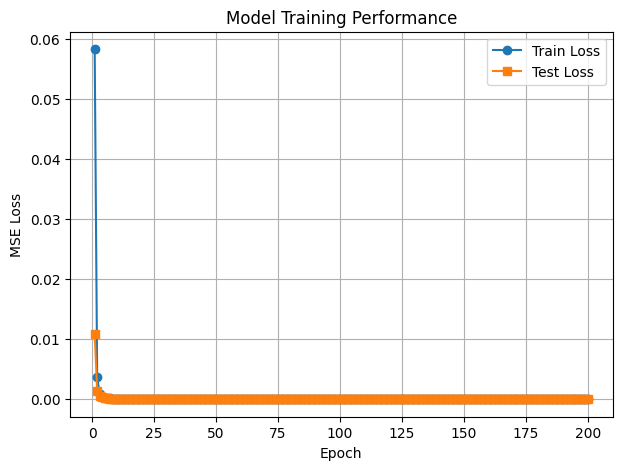

In [14]:
trained_model = main()

In [ ]:

eta_true   = 0.88
gamma_true = 0.015
eta_pred, gamma_pred = predict_single_example(
    trained_model,
    eta_true, gamma_true,
    eps_gkp=0.05,
    in_state=(0,0),
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6)
)
print(f"[Single example] True: (eta={eta_true:.3f}, gamma={gamma_true:.4f})")
print(f"[Single example] Pred: (eta={eta_pred:.3f}, gamma={gamma_pred:.4f})")

[Single example] True: (eta=0.880, gamma=0.0150)
[Single example] Pred: (eta=0.881, gamma=0.0169)


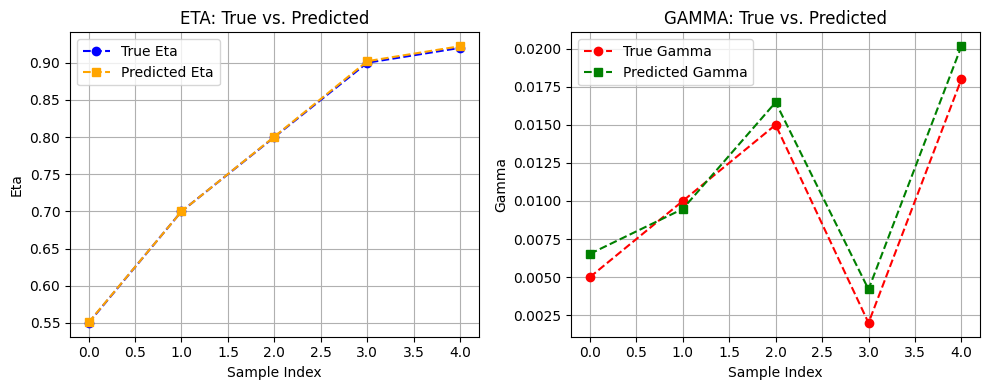

In [16]:

test_params = [
    (0.55, 0.005),
    (0.70, 0.010),
    (0.80, 0.015),
    (0.90, 0.002),
    (0.92, 0.018)
]
plot_prediction_performance(
    trained_model,
    test_params,
    eps_gkp=0.05,
    in_state=(0,0),
    q_pts=32,
    range_q=(-6,6),
    range_p=(-6,6)
)
